# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


Using TensorFlow backend.


170500096/170498071 [==============================] - 209s   
Untaring file...


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

[6]


In [6]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = (len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0]))

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 10

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 50000
Number of testing examples = 10000
Image data shape = (32, 32, 3)
Number of classes = 10


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Count of each sign in training data set


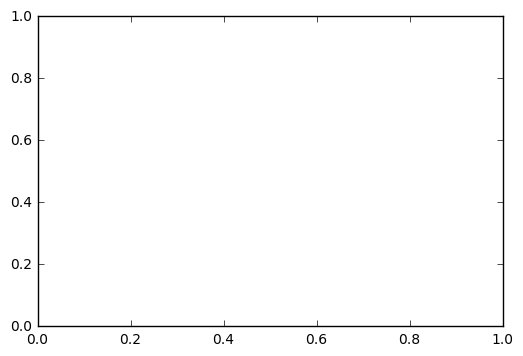

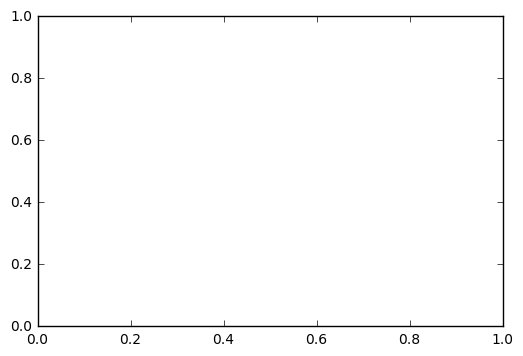

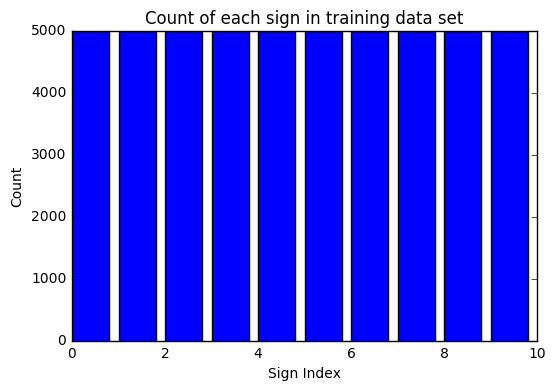

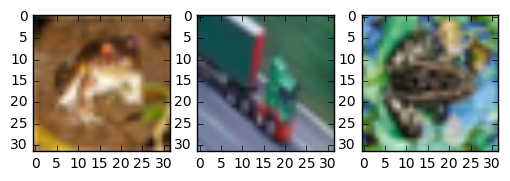

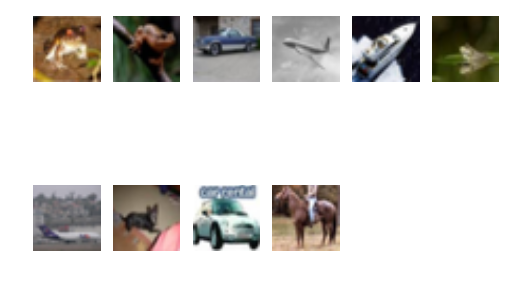

RGB value for a single pixel: [59 62 63]


In [10]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import math
# Visualizations will be shown in the notebook.

# plot count of each sign in training set
#plt.figure(0)
fig, ax = plt.subplots()
signs = np.asarray(y_train)
y_pos = np.arange(n_classes)
signCounts = []
print('Count of each sign in training data set')
for i in range(n_classes):
    condArr = np.where(y_train==i)[0]
    signCounts.append(condArr.size)
bar1 = ax.bar(y_pos, signCounts)
ax.set_xlabel('Sign Index')
ax.set_ylabel('Count')
ax.set_title('Count of each sign in training data set')
plt.show()

# plot some sample images.
# Note how it looks like much care was taken to have images of the same sign with varying brightness/sharpness.
# Makes sense... traffic signs of the same type are mostly alike but conditions under which image is aquired vary a lot.
plt.figure(1)
plt.subplot(131)
plt.imshow(X_train[0])
plt.subplot(132)
plt.imshow(X_train[50])
plt.subplot(133)
plt.imshow(X_train[200])

# plot one image of each sign
plt.figure(2)
subplotY = 6
subplotX = math.ceil(n_classes / subplotY)
imgIndex = 0
for i in range(n_classes):
    plt.subplot(subplotX, subplotY, i+1)
    plt.imshow(X_train[imgIndex])
    plt.axis('off')
    imgIndex = imgIndex + signCounts[i]

plt.show()

# print one RGB value to see the range
print('RGB value for a single pixel: %s' % X_train[0][0][0])


%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

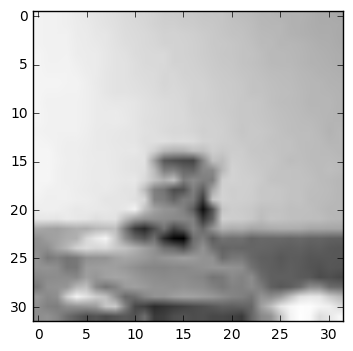

In [11]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.preprocessing import normalize
import cv2

# more efficient RGB to greyscale conversion. From:
# http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
# added default scale of 0..255 to -0.5..0.5
# added normalization
def rgb2gray(rgb, normalize = False):
    # RGB to Luminance
    rF = 0.299
    gF = 0.587
    bF = 0.114
    grey =  np.dot(rgb[...,:3], [rF, gF, bF])
    if normalize:
        # per image, normalize via min-max scaling
        for i in range(len(grey)):
            a = -0.5
            b = 0.5
            greyscale_min = np.amin(grey[i])
            greyscale_max = np.amax(grey[i])
            grey[i] = a + ( ( (grey[i] - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )
    return grey
    

X_trainData = rgb2gray(X_train[:][:], normalize = True)
X_testData = rgb2gray(X_test[:][:], normalize = True)
# debug greyscale conversion
plt.figure(3)
plt.imshow(X_trainData[100], cmap = plt.get_cmap('gray'), vmin=-0.5, vmax=0.5)
plt.show()

'''
Implementation to apply properly scaled bounding boxes to training and test data. Not sure if it's a good idea to actually use it...
# Bounding box implementation. Sets every pixel outside of mask to zero.
def region_of_interest(greyScale, mask):
    for x in range(len(greyScale[0])):
        for y in range(len(greyScale[1])):
            if x<mask[0] or x>mask[2] or y<mask[1] or y>mask[3]:
                greyScale[x][y] = 0.0
    return greyScale
# apply BB to training data
X_trainCoords = np.asarray(X_trainCoords)
X_trainSizes = np.asarray(X_trainSizes)
X_trainSizesScaled = 32 / X_trainSizes
X_trainSizesScaled = np.concatenate((X_trainSizesScaled, X_trainSizesScaled), axis=1)
X_trainCoordsScaled = X_trainCoords * X_trainSizesScaled
X_trainDataBB = []
for i in range(len(X_trainData)):
    X_trainDataBB.append(region_of_interest(X_trainData[i],X_trainCoordsScaled[i]))
# apply BB to test data
X_testCoords = np.asarray(X_testCoords)
X_testSizes = np.asarray(X_testSizes)
X_testSizesScaled = 32 / X_testSizes
X_testSizesScaled = np.concatenate((X_testSizesScaled, X_testSizesScaled), axis=1)
X_testCoordsScaled = X_testCoords * X_testSizesScaled
X_testDataBB = []
for i in range(len(X_testData)):
    X_testDataBB.append(region_of_interest(X_testData[i],X_testCoordsScaled[i]))
print('done')
'''
pass # prevents annoying output of above commented out block

### Question 1

Describe how you preprocessed the data. Why did you choose that technique?

**Answer:**

I converted the training and test data to greyscale (YUV conversion, stripping U and V).

Traffic signs are unique and there are no two traffic signs that are only distinguishable by color (at least not in Germany). Eliminating color information (two of the three data channels) seemed reasonable.

The resulting greyscale values were normalized to be between -0.5 to 0.5 and centered around 0.0 in order to keep the problem well-conditioned.

In [12]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

train_features, valid_features, train_labels, valid_labels = train_test_split(
X_trainData,
y_train,
test_size=0.20,
random_state=42,
stratify=y_train)
'''
# create jittered training data set
train_jittered = []
train_labels_jittered = []
for i in range(len(train_features)):
    for j in range(4):
        offsetX = random.uniform(-2., 2.)
        offsetY = random.uniform(-2., 2.)
        rot = random.uniform(-15., 15.)
        scale = random.uniform(0.9, 1.1)
        train_jittered.append(jitterImg(train_features[i], offsetX, offsetY, rot, scale))
        train_labels_jittered.append(train_labels[i])

# shuffle newly created training set
#train_jittered, train_labels_jittered = shuffle(train_jittered, train_labels_jittered)
train_labels_jittered = np.asarray(train_labels_jittered)
'''



'\n# create jittered training data set\ntrain_jittered = []\ntrain_labels_jittered = []\nfor i in range(len(train_features)):\n    for j in range(4):\n        offsetX = random.uniform(-2., 2.)\n        offsetY = random.uniform(-2., 2.)\n        rot = random.uniform(-15., 15.)\n        scale = random.uniform(0.9, 1.1)\n        train_jittered.append(jitterImg(train_features[i], offsetX, offsetY, rot, scale))\n        train_labels_jittered.append(train_labels[i])\n\n# shuffle newly created training set\n#train_jittered, train_labels_jittered = shuffle(train_jittered, train_labels_jittered)\ntrain_labels_jittered = np.asarray(train_labels_jittered)\n'

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

From several online papers about this particular training set, I gathered that images for each sign came from individual 30-frame videos. I checked the number of samples (all divisible by 30) and looked at random 30-frame intervals of images - and the version of the data that came with this problem is still divided the same way.
This has implications on the creation of the validation set - I *intended* to make sure that I don't use images from the same 30-frame sequence in both training and validation sets. However, data that belongs label #33 was not divisible by 30, so part of that sequence was clearly missing (which made me doubt if there aren't more missing/extra frame across the data).

Due to that uncertainty, I ended up going with a random split of the training set to create the validation set. My validation set consists of 7,842 samples (20% of training set). I used the stratify flag in train_test_split in order to keep the relative occurence of each sign the same across the validation and training set.

Taking a cue from the Lecun paper, I jittered the test data to introduce more real-world variance. For each image, I added 4 transformed versions of the original training set, yielding 125,468 samples in total. Samples are randomly perturbed in position ([-2,2] pixels), in scale ([.9,1.1] ratio) and rotation ([-15,+15] degrees).

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

tf.reset_default_graph()

def convNet(x, dropout):    
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 1))
    # 32x32x1
    
    # CONVOLUTION LAYER 1
    conv1W = tf.Variable(tf.truncated_normal(shape=[3,3,1,50], stddev=0.2), name='conv1W')
    conv1B = tf.Variable(tf.truncated_normal(shape=[50], stddev=0.2), name='conv1B')
    conv1 = tf.nn.conv2d(x, conv1W, strides = [1,1,1,1], padding='SAME')
    conv1 = tf.nn.bias_add(conv1, conv1B)
    # 32x32x50
    conv1 = tf.nn.relu(conv1)
    # CONVOLUTION LAYER 2
    conv2W = tf.Variable(tf.truncated_normal(shape=[3,3,50,50], stddev=0.2), name='conv2W')
    conv2B = tf.Variable(tf.truncated_normal(shape=[50], stddev=0.2), name='conv2B')
    conv2 = tf.nn.conv2d(conv1, conv2W, strides = [1,1,1,1], padding='SAME')
    conv2 = tf.nn.bias_add(conv2, conv2B)
    # 32x32x50
    conv2 = tf.nn.relu(conv2)
    maxp1 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    # 16x16x50
    
    # CONVOLUTION LAYER 3
    conv3W = tf.Variable(tf.truncated_normal(shape=[3,3,50,100], stddev=0.2), name='conv3W')
    conv3B = tf.Variable(tf.truncated_normal(shape=[100], stddev=0.2), name='conv3B')
    conv3 = tf.nn.conv2d(maxp1, conv3W, strides = [1,1,1,1], padding='SAME')
    conv3 = tf.nn.bias_add(conv3, conv3B)
    # 16x16x100
    conv3 = tf.nn.relu(conv3)
    # CONVOLUTION LAYER 4
    conv4W = tf.Variable(tf.truncated_normal(shape=[3,3,100,100], stddev=0.2), name='conv4W')
    conv4B = tf.Variable(tf.truncated_normal(shape=[100], stddev=0.2), name='conv4B')
    conv4 = tf.nn.conv2d(conv3, conv4W, strides = [1,1,1,1], padding='SAME')
    conv4 = tf.nn.bias_add(conv4, conv4B)
    # 16x16x100
    conv4 = tf.nn.relu(conv4)
    maxp2 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    # 8x8x100
    
    ## FULLY CONNECTED LAYER 1
    fc1 = flatten(maxp2)
    # 6400
    fc1_shape = (fc1.get_shape().as_list()[-1], 1000)
    fc1W = tf.Variable(tf.truncated_normal(shape=fc1_shape, stddev=0.2), name='fc1W')
    fc1B = tf.Variable(tf.truncated_normal(shape=[1000], stddev=0.2), name='fc1B')
    fc1 = tf.add(tf.matmul(fc1, fc1W), fc1B)
    # 1000
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    ## FULLY CONNECTED OUTPUT LAYER
    logitW = tf.Variable(tf.truncated_normal(shape=[1000, n_classes], stddev=0.2), name='logitW')
    logitB = tf.Variable(tf.truncated_normal(shape=[n_classes], stddev=0.2), name='logitB')
    return tf.add(tf.matmul(fc1, logitW), logitB)
    # 10

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
My architecture has seven hidden layers:

INPUT -> 32x32x1  
Convolution (3x3 filter) -> 32x32x50  
Convolution (3x3 filter) -> 32x32x50  
MaxPool -> 16x16x50  
Convolution (3x3 filter) -> 16x16x100  
Convolution (3x3 filter) -> 32x32x50  
MaxPool -> 8x8x100  
Fully Connected -> 1000  
OUTPUT

I ran into overfitting issues at higher epochs and solved those by adding Dropout to the fully connected layer.

In [18]:
### Train your model here.
### Feel free to use as many code cells as needed.

from sklearn.preprocessing import OneHotEncoder
import tqdm
import os

EPOCHS = 25
BATCH_SIZE = 50
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.5

# 32x32x1, grayscale images
x = tf.placeholder(tf.float32, (None, 32, 32), name='x')
# Classify over 10 digits 0-9
y = tf.placeholder(tf.float32, (None, 10), name='y')
dropout = tf.placeholder(tf.float32, name='dropout')
logits = convNet(x, dropout)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
opt = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# One-Hot Encoding from Udacity forum
# https://carnd-forums.udacity.com/display/CAR/questions/15699319/how-to-one-hot-encode-the-german-data---project-2
def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

def eval_data(features, labels):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    num_examples = len(features)
    batch_count = num_examples // BATCH_SIZE
    total_acc, total_loss = 0, 0
    sess = tf.get_default_session()
    currentBatchStart = 0
    for batch_i in range(batch_count):
        currentBatchStart = batch_i * BATCH_SIZE
        currentBatchEnd = min((currentBatchStart+BATCH_SIZE),len(features))
        batch_x = features[currentBatchStart:currentBatchEnd]
        batch_y = labels[currentBatchStart:currentBatchEnd]
        # one-hot encode!
        batch_y = OHE_labels(batch_y, 10)
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, dropout: 1.})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    startEpoch = 0
    num_examples = len(train_features)
    batch_count = num_examples // BATCH_SIZE    
    # Train model
    for epoch_i in range(EPOCHS):
        currentBatchStart = 0
        # Progress bar
        batches_pbar = tqdm.tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, EPOCHS), unit='batches')
        for batch_i in batches_pbar:
        #for batch_i in range(batch_count):
            currentBatchStart = batch_i * BATCH_SIZE
            currentBatchEnd = min((currentBatchStart+BATCH_SIZE),len(train_features))
            batch_x = train_features[currentBatchStart:currentBatchEnd]
            batch_y = train_labels[currentBatchStart:currentBatchEnd]
            # one-hot encode
            batch_y = OHE_labels(batch_y, 10)
            loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y, dropout: DROPOUT_RATE})

        val_loss, val_acc = eval_data(valid_features, valid_labels)
        print('EPOCH %s, Validation loss = %s, Validation accuracy = %s' % ((epoch_i+1), format(val_loss, '.2f'), format(val_acc, '.2f')))
    
    # Evaluate on the test data
    test_loss, test_acc = eval_data(X_testData, y_test)
    print("Test accuracy = {:.3f}".format(test_acc))


Epoch  1/25:   3%|█▊                                                                     | 21/800 [00:01<01:44,  7.43batches/s]Exception in thread Thread-18:
Traceback (most recent call last):
  File "d:\Program Files\Anaconda3\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "d:\Program Files\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "d:\Program Files\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Epoch  1/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 35.70batches/s]


EPOCH 1, Validation loss = 2.00, Validation accuracy = 0.27


Epoch  2/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.74batches/s]


EPOCH 2, Validation loss = 1.88, Validation accuracy = 0.31


Epoch  3/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.72batches/s]


EPOCH 3, Validation loss = 1.76, Validation accuracy = 0.36


Epoch  4/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.96batches/s]


EPOCH 4, Validation loss = 1.69, Validation accuracy = 0.38


Epoch  5/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.70batches/s]


EPOCH 5, Validation loss = 1.62, Validation accuracy = 0.42


Epoch  6/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 37.01batches/s]


EPOCH 6, Validation loss = 1.61, Validation accuracy = 0.44


Epoch  7/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.99batches/s]


EPOCH 7, Validation loss = 1.48, Validation accuracy = 0.48


Epoch  8/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.93batches/s]


EPOCH 8, Validation loss = 1.37, Validation accuracy = 0.52


Epoch  9/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.96batches/s]


EPOCH 9, Validation loss = 1.29, Validation accuracy = 0.55


Epoch 10/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 35.61batches/s]


EPOCH 10, Validation loss = 1.24, Validation accuracy = 0.57


Epoch 11/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 37.07batches/s]


EPOCH 11, Validation loss = 1.18, Validation accuracy = 0.59


Epoch 12/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.35batches/s]


EPOCH 12, Validation loss = 1.17, Validation accuracy = 0.60


Epoch 13/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 37.09batches/s]


EPOCH 13, Validation loss = 1.16, Validation accuracy = 0.62


Epoch 14/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.19batches/s]


EPOCH 14, Validation loss = 1.18, Validation accuracy = 0.63


Epoch 15/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.97batches/s]


EPOCH 15, Validation loss = 1.16, Validation accuracy = 0.64


Epoch 16/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 36.31batches/s]


EPOCH 16, Validation loss = 1.25, Validation accuracy = 0.64


Epoch 17/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 35.91batches/s]


EPOCH 17, Validation loss = 1.20, Validation accuracy = 0.65


Epoch 18/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 36.26batches/s]


EPOCH 18, Validation loss = 1.33, Validation accuracy = 0.65


Epoch 19/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 37.10batches/s]


EPOCH 19, Validation loss = 1.36, Validation accuracy = 0.65


Epoch 20/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.94batches/s]


EPOCH 20, Validation loss = 1.30, Validation accuracy = 0.66


Epoch 21/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 37.11batches/s]


EPOCH 21, Validation loss = 1.42, Validation accuracy = 0.66


Epoch 22/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 37.09batches/s]


EPOCH 22, Validation loss = 1.47, Validation accuracy = 0.67


Epoch 23/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 36.32batches/s]


EPOCH 23, Validation loss = 1.52, Validation accuracy = 0.66


Epoch 24/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 36.63batches/s]


EPOCH 24, Validation loss = 1.48, Validation accuracy = 0.67


Epoch 25/25: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 36.57batches/s]


EPOCH 25, Validation loss = 1.59, Validation accuracy = 0.67
Test accuracy = 0.671


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**  
Type of optimizer: AdamOptimizer (to take advantage of Momentum)  
Batch size = 50  
Epochs = 25  
Learning Rate = 0.001  
Dropout Rate = 0.5

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**  
I started with the LeNet implementation from our class and added layers/neurons iteratively.  
To get an idea of the general performance of my model, I started out making larger tweaks at small Epochs (<10). Once those initial results seemed promising, I would do a test run with a larger number of Epochs until I arrived at my current network.   

- Setting up tensorflow-gpu on my local PC (Windows 10) made it much easier to work with this project and enabled me to iterate within a reasonable timeframe.  
- Reducing the filter size on my convolution layers to 3x3 made my model much more stable. Training would run into states it would not recover from with 5x5 filters (stuck at 6% validation accuracy with decreasing loss)
- Using Truncate Normal for all variables (no zero() ), and tightening the standard deviation to 0.2 instead of the 1.0 default seemed to help quite a bit, too.
- The largest jump in test accuracy came from introducing Dropout - whereas before my test accuracy was tracking my validation accuracy within about 10% (and would simetimes succumb to overfitting), that gap reliably closed to under 5%.
- Before "jittering" my training data, I reached a test accuracy of 96.8% after 200 Epochs. Using the much larger set of jittered data, my test accuracy went up to 98% at only 150 Epochs.
- After my first submission to this project, it was pointed out to me that something must be wrong that my model reaches 1.0 certainties when running softMax probabilities on the new test images below. So I started looking into saving/restoring a TensorFlow model in more detail. After I figured out how to save and restore checkpoints cleanly, I reran my model and kept checkpoints at 25 Epoch intervals. It turns out that my final model reached diminishing results after about 25 Epochs. It would have been worth to implement a way to stop the training once the values cease to improve markedly.  

**I ended up with a test accuracy of 97.6%.**

---

### Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

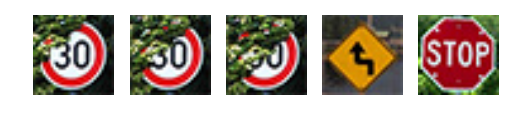

In [9]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import glob

os.listdir("extraSigns/")
image_list = glob.glob('extraSigns/*.jpg')
imgIndex = 0
subplotX = 1
subplotY = len(image_list)
newImgData = []
for each in image_list:
    img = mpimg.imread(each)
    newImgData.append(img)
    plt.subplot(subplotX, subplotY, imgIndex+1)
    plt.imshow(img)
    plt.axis('off')
    plt.imshow(img)
    imgIndex += 1
newImgData = np.asarray(newImgData)
plt.show()

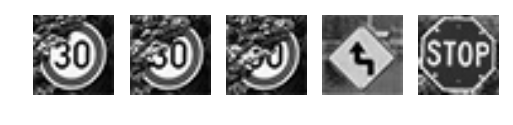

In [10]:
# prep image data
X_newImgData = rgb2gray(newImgData[:][:], normalize = True)
imgIndex = 0
subplotX = 1
subplotY = len(image_list)
for each in X_newImgData:
    plt.subplot(subplotX, subplotY, imgIndex+1)
    plt.imshow(img)
    plt.axis('off')
    plt.imshow(each, cmap = plt.get_cmap('gray'), vmin=-0.5, vmax=0.5)
    imgIndex += 1
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**  
I chose the five candidate images for the following reasons:    
  
**Sequence of obstructed 30 km/h signs:**  
Traffic signs are often obstructed in some way. A tree getting between the camera's POV and the sign is a realistic scenario. I photoshopped an increasingly larger obstruction over the image to see if and when the classification will fail.  
  
**"Left reverse turn ahead" sign**:  
This is outside of the training set. I wanted to see what my model thinks this might be.  
  
**Stop sign**:  
This is a US stop sign... but they all look the same. This should be correctly classified.  

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

y_new = [1,1,1,21,14]
#sess_new = tf.Session()

softMax = tf.nn.softmax(logits)
topFiveSoftMax=tf.nn.top_k(tf.nn.softmax(logits), k=5, sorted=True, name=None)
new_saver = tf.train.Saver()
'''
SoftMax probabilities for final result of model (150 epochs) returned 1.0 values for each predicted sign. Not useful.
My model's gain in test accuracy stalled out after about 25 Epochs.
I am using the associated checkpoint moving forward.
'''
file = 'convNet_50Cx50CxMx100Cx100CxMx1000F_50Drop.ckpt-25'
save_file = os.getcwd() + '/' + file

with tf.Session() as sess_new:
    #sess_new.run(tf.global_variables_initializer())
    new_saver.restore(sess_new, save_file)
    pred_new, topFiveSoftMax_new, softMax_new = sess_new.run([logits,topFiveSoftMax, softMax], feed_dict={x: X_newImgData, dropout: 1.0})
yPred_new = np.argmax(pred_new,axis=1)

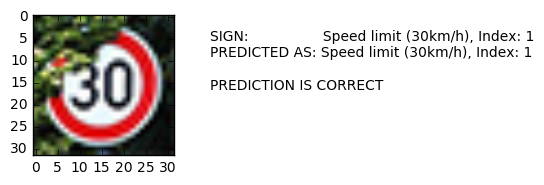

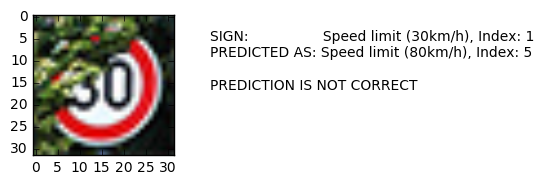

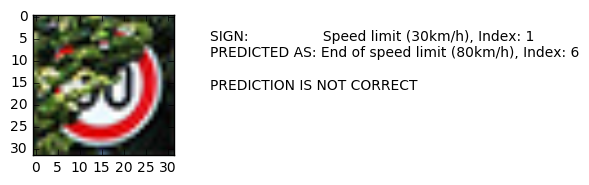

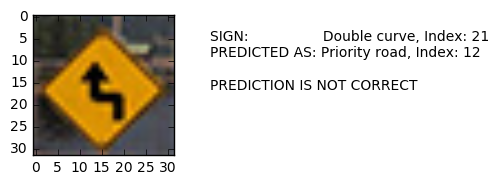

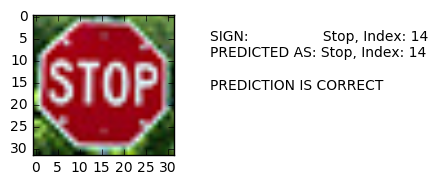

In [14]:
for i in range(5):
    actualIndex = y_new[i]
    predictionIndex = yPred_new[i]
    text = 'SIGN:                 %s, Index: %s\n' % (signDict[str(actualIndex)] ,actualIndex)
    text += 'PREDICTED AS: %s, Index: %s\n\n' % (signDict[str(predictionIndex)], predictionIndex)
    corPred = 'NOT CORRECT'
    if (actualIndex == predictionIndex):
        corPred = 'CORRECT'
    text += 'PREDICTION IS %s' % (corPred)
    fig = plt.figure(i)
    ax = fig.add_subplot(211, autoscale_on=True)
    img = mpimg.imread(image_list[i])
    plt.imshow(img)
    ax.annotate(text, fontsize=10, xy=(.25, .75),
                xycoords='data', xytext=(125, -50),
                textcoords='offset points'
                )

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**  
The prediction accuracy for this new set of images is **40%**. Significantly worse than the test set performance.

**Sequence of obstructed 30 km/h signs:**  
The first two are detected correctly, but the second and third one are too obstructed. It still makes a pretty good guess at predicting the second sign, but predicts it as 80km/h instead of 30km/h. It still thinks the numbers third image are "80", but classifies the image as "End of Speed Limit" - probably because the obstruction cuts through the sign's center diagonally, just like the (falsely) classified sign.  
My model does not perform very well with the partially obstructed signs, but neither would a human in this case. With more information about the sign as the car approaches it and gets different looks at it through the obstruction, one can probably use that information to make a more robust classification.  
  
**"Left reverse turn ahead" sign**:  
There is a sign in the german set at index 21 that has a similar symbol, but the shape of the sign is a triangle instead of a diamond like in the US-sign. The diamond shape has the larger influence on the prediction, however, and my model identifies it as the only diamond-shaped sign in the german set ("Priority road").  
  
**Stop sign**:  
They look the same, so no problem here.  

In [81]:
print(indeces)
print(softMax_new[0])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[  0.00000000e+00   1.00000000e+00   1.62949241e-25   2.80259693e-44
   0.00000000e+00   1.30869275e-28   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.62397686e-38   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   3.50324616e-44   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.12103877e-44   1.40129846e-45   0.00000000e+00]


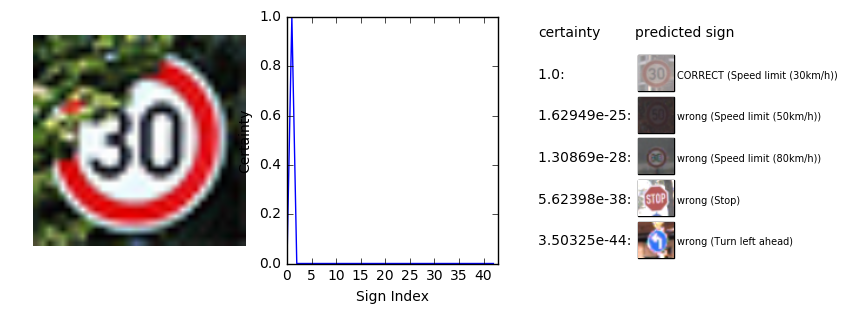

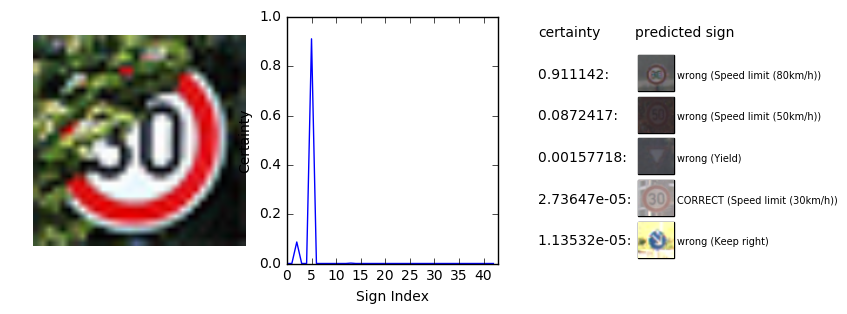

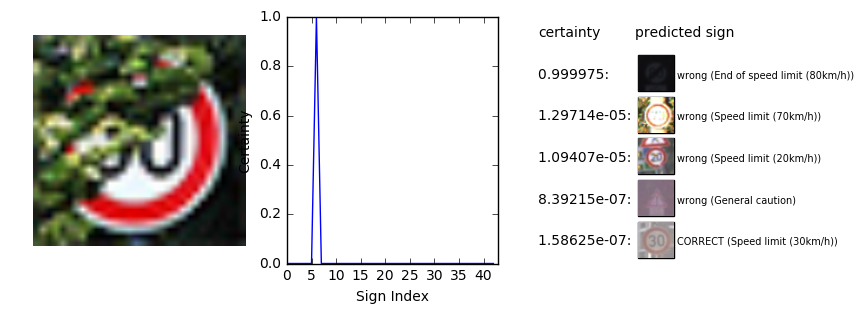

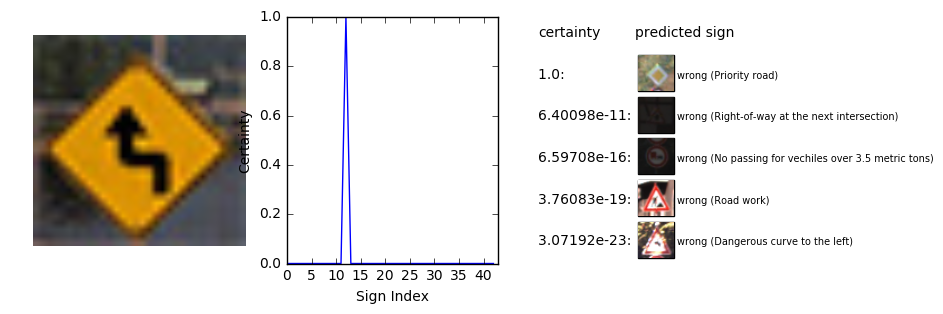

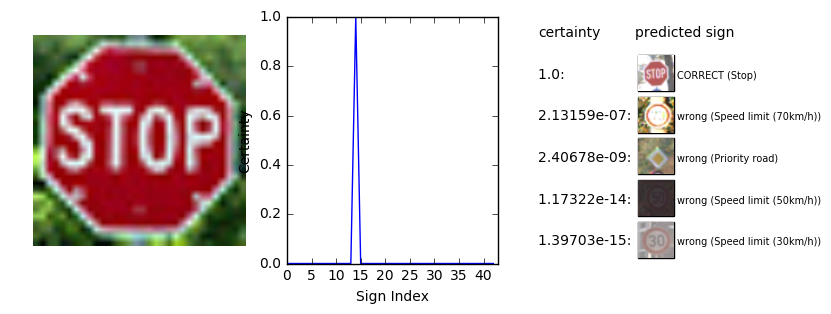

In [78]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

indeces = list(range(0,43))
globAnnY_offset = 20
#fig = plt.figure()
#ax = fig.add_subplot(111, autoscale_on=False)


subplotX = 2
subplotY = 1

for i in range(5):
    fig = plt.figure(i)
    fig.set_figheight(7)
    
    img = mpimg.imread(image_list[i])
    plt.subplot(221)
    plt.axis('off')
    plt.imshow(img)
    
    ax = plt.subplot(222)
    plt.axis('on')
    ax.plot(indeces, softMax_new[i])
    ax.set_ylim(0., 1.)
    ax.set_xlim(0, 43)
    ax.set_xlabel('Sign Index')
    ax.set_ylabel('Certainty')
    
    annY_offset = 30
    ax.annotate('certainty', fontsize=10, xy=(.25, .75),
                    xycoords='data', xytext=(180, annY_offset),
                    textcoords='offset points'
                    )
    ax.annotate('predicted sign', fontsize=10, xy=(.25, .75),
                xycoords='data', xytext=(250, annY_offset),
                textcoords='offset points')
    
    
    
    for j in range(5):
        if topFiveSoftMax_new[0][i][j] > -0.1:
            annY_offset -= 30
            text = '%s: ' % topFiveSoftMax_new[0][i][j]
            ax.annotate(text, fontsize=10, xy=(.25, .75),
                    xycoords='data', xytext=(180, annY_offset),
                    textcoords='offset points'
                    )
            signIndex = np.argmax(y_train>topFiveSoftMax_new[1][i][j]-1)
            sign = X_train[signIndex]
            imagebox = OffsetImage(sign, zoom=1.12)
            ab = AnnotationBbox(imagebox, xy=(.25, .75),
                            xybox=(265, annY_offset+4),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.0
                            )
            ax.add_artist(ab)
            text = 'wrong'
            if (topFiveSoftMax_new[1][i][j] == y_new[i]):
                text = 'CORRECT'
            text += ' (%s)' % signDict[str(topFiveSoftMax_new[1][i][j])]
            ax.annotate(text, fontsize=7, xy=(.25, .75),
                    xycoords='data', xytext=(280, annY_offset),
                    textcoords='offset points'
                    )

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**  
Once I created the much larger jittered training data set, my model become **much** more certain about these new test images. I now get extremely high probabilities (approaching 1.0) for whichever sign the model is most certain about. At 25 Epochs, there are still a few other non-zero probabilities... those do dissappear at higher Epoch numbers. As noted above, since I am getting diminishing results beyond 25 epochs, I am using that as my model for the sake of this excercise.
  
**Sequence of obstructed 30 km/h signs:**  
My model is extremely certain that the first sign are indeed a 30km/h sign. The next lower probabilities are also all speed limit signs, which is encouraging.  
The certainties flip in the second image. It is now classified as a 80km/h sign. The model still sees an extremely tiny probability of it being a 30km/h sign, which comes in at fourth place in the classification. For the third one, the correct 30km/h sign also still comes in at fifth in the classification.
  
**"Left reverse turn ahead" sign**:  
The model is very certain that the diamond shape makes it a "Priority Road" sign (the only diamond-shaped sign in the german set). It might pick up on the arrow shape like I was hoping for in the second placed classification (right-of-way at next intersection), which has a large arrow in the center.
  
**Stop sign**:  
Very certain that it is, indeed, a stop sign.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.